In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Driven Cavity

In this example we solve the two-dimensional incompressible steady Navier Stokes equations in the Driven Cavity problem

$$
\mathbf{u} \cdot \nabla \mathbf{u} = \frac{1}{Re} \nabla^2 \mathbf{u} - \nabla p
$$

where $\mathbf{u} = (u, v)$ is the velocity of the fluid and $Re$ is the Reynolds number. The geometry of the problem is described as follows

![](https://www.cfd-online.com/W/images/a/a3/Ldc_geom.png)

In [2]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.7.0')

In [3]:
U = 1.
Re = 100

class NavierStokes2d(PDE):
    def computePDELoss(self, inputs, outputs):
        
        u, v, p = outputs[:, 0], outputs[:, 1], outputs[:, 2]
        
        # first order derivatives        
        grads = self.computeGrads(u, inputs)       
        dudx, dudy = grads[:, 0], grads[:, 1]
        
        grads = self.computeGrads(v, inputs)       
        dvdx, dvdy = grads[:, 0], grads[:, 1]
        
        grads = self.computeGrads(p, inputs)       
        dpdx, dpdy = grads[:, 0], grads[:, 1]
            
        # second order derivatives        
        du2dx2 = self.computeGrads(dudx, inputs)[:, 0]       
        du2dy2 = self.computeGrads(dudy, inputs)[:, 1]       
        dv2dx2 = self.computeGrads(dvdx, inputs)[:, 0]       
        dv2dy2 = self.computeGrads(dvdy, inputs)[:, 1]       

        
        # compute losses
        return {
            'mass': dudx + dvdy,
            'mom_x': u*dudx + v*dudy + dpdx - (1./Re)*(du2dx2 + du2dy2),
            'mom_y': u*dvdx + v*dvdy + dpdy - (1./Re)*(dv2dx2 + dv2dy2)
        }

# instanciate pde
pde = NavierStokes2d(inputs=('x', 'y'), outputs=('u', 'v', 'p'))

In [4]:
# mesh 

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

mesh = Mesh({'x': x, 'y': y}, device=device)
pde.set_mesh(mesh)

In [5]:
# left-right walls

class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdx = self.computeGrads(outputs[:, 2], inputs)[:, 0]
        return {'gradX': dpdx}

u0 = np.zeros(2*len(y))
v0 = np.zeros(2*len(y))
boco = Dirichlet({'x': np.array([0, 1]), 'y': y}, {'u': u0, 'v': v0}, name='x_w_d', device=device)
pde.add_boco(boco)

boco = NeumannX({'x': np.array([0, 1]), 'y': y}, name='x_w_n', device=device)
pde.add_boco(boco)

Boco x_w_d with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


In [6]:
# bootom wall

class NeumannY(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        dpdy = self.computeGrads(outputs[:, 2], inputs)[:, 1]
        return {'gradY': dpdy}

u0 = np.zeros(len(x))
v0 = np.zeros(len(x))
boco = Dirichlet({'x': x, 'y': np.array([0])}, {'u': u0, 'v': v0}, name='b_w_d', device=device)
pde.add_boco(boco)

   
boco = NeumannY({'x': x, 'y': np.array([0])}, name='b_w_n', device=device)
pde.add_boco(boco)

Boco b_w_d with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


In [7]:
# top wall

u0 = np.full(len(x), U)
v0 = np.zeros(len(x))
boco = Dirichlet({'x': x, 'y': np.array([1])}, {'u': u0, 'v': v0}, name='t_w_d', device=device)
pde.add_boco(boco)

boco = NeumannY({'x': x, 'y': np.array([1])}, name='t_w_n', device=device)
pde.add_boco(boco)

Boco t_w_d with different outputs ! ('u', 'v', 'p') vs ('u', 'v')


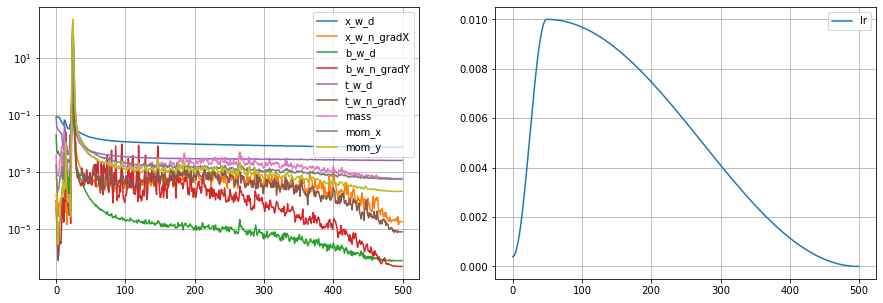

CPU times: user 7min 40s, sys: 6.05 s, total: 7min 46s
Wall time: 7min 44s


In [8]:
from nangs import MLP

BATCH_SIZE = 512
LR = 1e-2
EPOCHS = 500
NUM_LAYERS = 5
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

In [9]:
# evaluate the solution

x = np.linspace(0,1,50)
y = np.linspace(0,1,50)

eval_mesh = Mesh({'x': x, 'y': y}, device=device)
outputs = pde.eval(eval_mesh).cpu()

u = outputs[:, 0].view(len(x),len(y)).numpy()
v = outputs[:, 1].view(len(x),len(y)).numpy()
p = outputs[:, 2].view(len(x),len(y)).numpy()

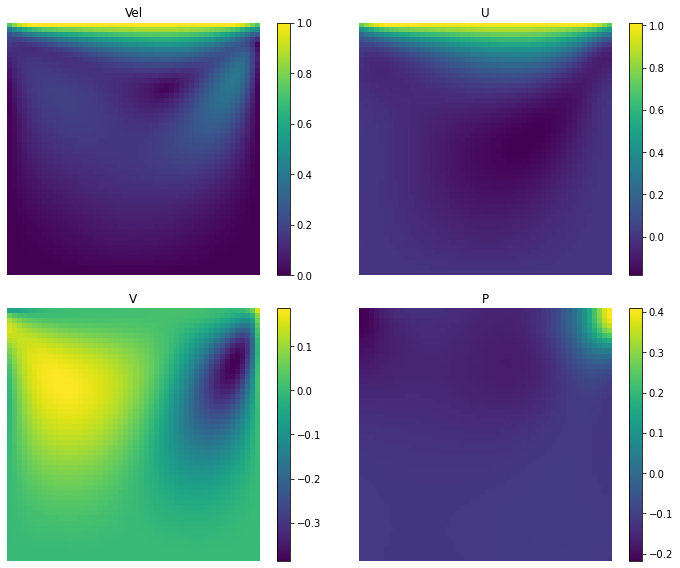

In [10]:
# plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
vel = np.sqrt(u**2 + v**2)
im=ax1.imshow(vel, vmin=0, vmax=1, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax1)
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax1.set_title("Vel")
ax1.axis(False)
im=ax2.imshow(u, vmin=u.min(), vmax=u.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax2)
ax2.set_title("U")
im=ax3.imshow(v, vmin=v.min(), vmax=v.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax3)
ax2.axis(False)
ax3.axis(False)
ax3.set_title("V")
im=ax4.imshow(p, vmin=p.min(), vmax=p.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax4)
ax4.axis(False)
ax4.set_title("P")
plt.tight_layout()
plt.show()

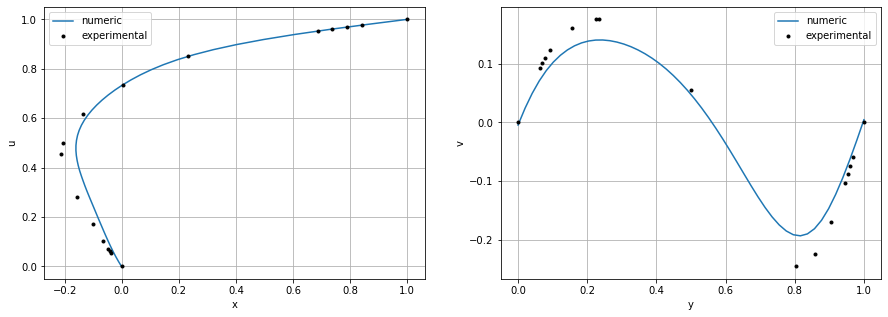

In [11]:
# profiles

mid_u = u[:,len(u)//2]
mid_v = v[len(v)//2,:]
exp_u = pd.read_csv('data/dc_100_ux.csv', header=None).values
exp_v= pd.read_csv('data/dc_100_uy.csv', header=None).values

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1.plot(mid_u, y, label="numeric")
ax1.plot(exp_u[:,0], exp_u[:,1], '.k', label="experimental")
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.legend()
ax1.grid(True)
ax2 = plt.subplot(122)
ax2.plot(x,mid_v, label="numeric")
ax2.plot(exp_v[:,0], exp_v[:,1], '.k', label="experimental")
ax2.legend()
ax2.set_xlabel('y')
ax2.set_ylabel('v')
ax2.grid(True)
plt.show()